In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf

%matplotlib inline

In [2]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

In [3]:
# Load the dataset
file_path = Path("tweets_cleaned.csv")
df_tweets = pd.read_csv(file_path)
df_tweets.head(10)

,sentiment,score,tweet
0,1,2.726316,Somehow I was blessed with some really amazing...
1,1,1.443299,Yay. Another good phone interview.
2,1,2.873684,We were 17 deep last night amp the love was so...
3,1,2.857143,"LMAO, AMAZING!"
4,0,-2.154639,Two words that should die this year: Sexting a...
5,1,2.510870,"Today I'm grateful for good food, good wine an..."
6,0,-1.360825,"Damn, running late sucks."
7,1,0.131313,Opal Divine's with the FSN crew.
8,0,-1.773196,Ugh. I hate hate hate getting blood drawn.
9,1,2.724490,Love love love that I just hung with @anonymou...


In [4]:
# Create the features set (X) and the target vector (y)
X = df_tweets["tweet"].values
y = df_tweets["sentiment"].values

In [5]:
# Create the train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

## Vader Sentiment

In [6]:
# Import the libraries for sentiment scoring using Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [7]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yutta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [9]:
# Define two lists to store vader sentiment scoring
y_vader_pred = []
y_vader_prob = []

In [10]:
# Score sentiment of test set using Vader
for comment in X_test:
    y_vader_prob.append(analyzer.polarity_scores(comment)["pos"])
    sentiment_score = analyzer.polarity_scores(comment)["compound"]
    if sentiment_score >= 0.1:
        y_vader_pred.append(1)
    else:
        y_vader_pred.append(0)

In [11]:
# Normalizing data using MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm = scaler.transform(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm[:5]

array([[0.203],
       [0.495],
       [0.247],
       [0.452],
       [0.   ]])

## SPACY

In [12]:
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X, y)

X_train_spacy, X_val_spacy, y_train_spacy, y_val_spacy = train_test_split(X_train_spacy, y_train_spacy)

In [13]:
# https://spacytextblob.netlify.app/
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")

# pipeline contains component name
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'spacytextblob']


In [14]:
y_spacy_pred = []
y_spacy_prob = []

In [15]:
for comment in X_test:
    y_spacy_prob.append(f"{nlp(comment)._.polarity}")
    sentiment_score = int(nlp(comment)._.polarity)
    if sentiment_score >= 0.1:
        y_spacy_pred.append(1)
    else:
        y_spacy_pred.append(0)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(y_spacy_prob).reshape(-1,1))
y_spacy_prob_norm = scaler.transform(np.array(y_spacy_prob).reshape(-1,1))
y_spacy_prob_norm[:5]

array([[0.7375],
       [0.5   ],
       [0.75  ],
       [0.725 ],
       [0.525 ]])

## RNN LSTM

In [17]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [19]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'anonymous', token: 1
word: 'the', token: 2
word: 'i', token: 3
word: 'to', token: 4
word: 'a', token: 5


In [20]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [21]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

**Text comment**
{"Somehow I was blessed with some really amazing friends in my life who love me and send encouragement when I'm not feeling awesome. So lucky."}


In [22]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[1347, 3, 27, 1348, 19, 73, 71, 107, 175, 14, 16, 164, 101, 31, 25, 6, 326, 2235, 67, 30, 34, 207, 79, 26, 429]


In [23]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# Set the pad size
max_words = 16

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post")

In [25]:
# Creating training, validation, and testing sets using the encoded data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [26]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [27]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 32

In [28]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=140))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [29]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [30]:
# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 32)            297472    
_________________________________________________________________
lstm (LSTM)                  (None, 140)               96880     
_________________________________________________________________
dense (Dense)                (None, 1)                 141       
Total params: 394,493
Trainable params: 394,493
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Training the model
batch_size = 1
epochs = 8
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/8
2362/2362 [==============================] - 17s 7ms/step - loss: 0.6184 - accuracy: 0.6770 - tp: 714.1608 - tn: 95.5904 - fp: 313.2666 - fn: 58.9818 - precision: 0.6849 - recall: 0.9462 - auc: 0.6221 - val_loss: 0.4661 - val_accuracy: 0.7893 - val_tp: 477.0000 - val_tn: 145.0000 - val_fp: 100.0000 - val_fn: 66.0000 - val_precision: 0.8267 - val_recall: 0.8785 - val_auc: 0.8386
Epoch 2/8
2362/2362 [==============================] - 14s 6ms/step - loss: 0.2726 - accuracy: 0.9137 - tp: 727.8976 - tn: 350.0034 - fp: 61.1562 - fn: 42.9424 - precision: 0.9231 - recall: 0.9463 - auc: 0.9482 - val_loss: 0.5211 - val_accuracy: 0.7792 - val_tp: 453.0000 - val_tn: 161.0000 - val_fp: 84.0000 - val_fn: 90.0000 - val_precision: 0.8436 - val_recall: 0.8343 - val_auc: 0.8384
Epoch 3/8
2362/2362 [==============================] - 14s 6ms/step - loss: 0.0812 - accuracy: 0.9774 - tp: 752.1930 - tn: 399.0317 - fp: 16.2560 - fn: 14.5188 - precision: 0.9816 - recall: 0.9835 - auc: 0.9935 - val_lo

In [32]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1)

C:\Users\yutta\anaconda3\envs\algotrading\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
# save the model
model.save('rnn_model.h5')
del model

In [34]:
#load the model
from tensorflow.keras.models import load_model
model = load_model('rnn_model.h5')

In [35]:
# Accuracy
from sklearn.metrics import accuracy_score

print("Vader Accuracy: %.5f" % (accuracy_score(y_test, y_vader_pred)))
print("RNN LSTM Accuracy %.5f" % (accuracy_score(y_test_rnn, y_rnn_pred)))
print("SpaCy Accuracy: %.5f" % (accuracy_score(y_test_spacy, y_spacy_pred)))

Vader Accuracy: 0.93714
RNN LSTM Accuracy 0.79905
SpaCy Accuracy: 0.32952


In [36]:
# Import the confusion_matrix method from sklearn
from sklearn.metrics import confusion_matrix

Confusion Matrix VADER

In [37]:
# Confusion matrtix metrics from Vader
tn_vader, fp_vader, fn_vader, tp_vader = confusion_matrix(y_test, y_vader_pred).ravel()

# Dataframe to display confusion matrix from Vader
cm_vader_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_vader}", f"FP={fp_vader}"],
        "Negative(0)": [f"FN={fn_vader}", f"TN={tn_vader}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_vader_df.index.name = "Actual"
cm_vader_df.columns.name = "Predicted"
print("Confusion Matrix from Vader")
display(cm_vader_df)

Confusion Matrix from Vader


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=663,FN=37
Negative(0),FP=29,TN=321


Confusion Matrix SpaCy

In [38]:
# Confusion matrtix metrics from Vader
tn_spacy, fp_spacy, fn_spacy, tp_spacy = confusion_matrix(y_test_spacy, y_spacy_pred).ravel()

# Dataframe to display confusion matrix from Vader
cm_spacy_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_spacy}", f"FP={fp_spacy}"],
        "Negative(0)": [f"FN={fn_spacy}", f"TN={tn_spacy}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_spacy_df.index.name = "Actual"
cm_spacy_df.columns.name = "Predicted"
print("Confusion Matrix from SpaCy")
display(cm_spacy_df)

Confusion Matrix from SpaCy


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=26,FN=683
Negative(0),FP=21,TN=320


Confusion Matrix RNN LSTM

In [39]:
# Confusion matrtix metrics from the RNN LSTM model
tn_rnn, fp_rnn, fn_rnn, tp_rnn = confusion_matrix(y_test_rnn, y_rnn_pred).ravel()

# Dataframe to display confusion matrix from the RNN LSTM model
cm_rnn_df = pd.DataFrame(
    {
        "Positive(1)": [f"TP={tp_rnn}", f"FP={fp_rnn}"],
        "Negative(0)": [f"FN={fn_rnn}", f"TN={tn_rnn}"],
    },
    index=["Positive(1)", "Negative(0)"],
)
cm_rnn_df.index.name = "Actual"
cm_rnn_df.columns.name = "Predicted"
print("Confusion Matrix from the RNN LSTM Model")
display(cm_rnn_df)

Confusion Matrix from the RNN LSTM Model


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=571,FN=119
Negative(0),FP=92,TN=268


In [40]:
# Import the classification_report method from sklearn
from sklearn.metrics import classification_report

In [41]:
# Display classification report for Vader
print("Classification Report for Vader")
print(classification_report(y_vader_pred, y_test))

Classification Report for Vader
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       358
           1       0.95      0.96      0.95       692

    accuracy                           0.94      1050
   macro avg       0.93      0.93      0.93      1050
weighted avg       0.94      0.94      0.94      1050



In [42]:
print("Classification Report for SpaCY")
print(classification_report(y_spacy_pred, y_test_spacy))

Classification Report for SpaCY
              precision    recall  f1-score   support

           0       0.94      0.32      0.48      1003
           1       0.04      0.55      0.07        47

    accuracy                           0.33      1050
   macro avg       0.49      0.44      0.27      1050
weighted avg       0.90      0.33      0.46      1050



In [43]:
# Display classification report for the RNN LSTM Model
print("Classification Report for the RNN LSTM Model")
print(classification_report(y_rnn_pred, y_test_rnn))

Classification Report for the RNN LSTM Model
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       387
           1       0.83      0.86      0.84       663

    accuracy                           0.80      1050
   macro avg       0.79      0.78      0.78      1050
weighted avg       0.80      0.80      0.80      1050



In [44]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

In [45]:
# Data for ROC Curve - VADER
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(y_test, y_vader_prob_norm)

In [46]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [47]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

<AxesSubplot:title={'center':'Test ROC Curve - Vader (AUC=0.9323)'}, xlabel='FPR Test'>

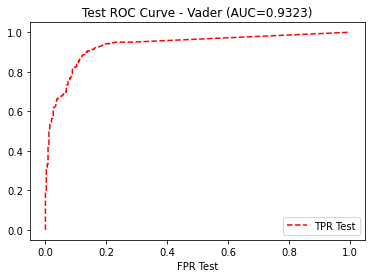

In [48]:
roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - Vader (AUC={auc_test_vader})",
)

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.4899)'}, xlabel='FPR Test'>

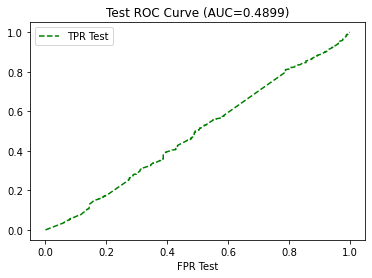

In [49]:
fpr_test_spacy, tpr_test_spacy, thresholds_test_spacy = roc_curve(y_test_spacy, y_spacy_prob_norm)
auc_test_spacy = auc(fpr_test_spacy, tpr_test_spacy)
auc_test_spacy = round(auc_test_spacy, 4)
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_spacy, "TPR Test": tpr_test_spacy,})
roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="green",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_spacy})",
)

In [50]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1)

In [51]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

In [52]:
# AUC for the RNN LSTM Model
auc_test_rnn = auc(fpr_test_rnn, tpr_test_rnn)
auc_test_rnn = round(auc_test_rnn, 4)

In [53]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_rnn, "TPR Test": tpr_test_rnn,})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.8796)'}, xlabel='FPR Test'>

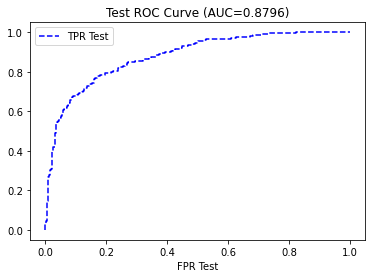

In [54]:
roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_rnn})",
)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

# Create feature vectors
#vectorizer = TfidfVectorizer(min_df = 5,
#                             max_df = 0.8,
#                             sublinear_tf = True,
#                             use_idf = True)
vectorizer = TfidfVectorizer(stop_words="english")

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

# Perform classification with SVM
classifier = svm.SVC(kernel='rbf')
classifier.fit(train_vectors, y_train)
prediction = classifier.predict(test_vectors)

In [56]:
print("Classification Report for Vader")
print(classification_report(prediction, y_test))

Classification Report for Vader
              precision    recall  f1-score   support

           0       0.41      0.91      0.57       159
           1       0.98      0.77      0.86       891

    accuracy                           0.79      1050
   macro avg       0.70      0.84      0.72      1050
weighted avg       0.89      0.79      0.82      1050



In [57]:
fpr_test_svm, tpr_test_svm, thresholds_test_svm = roc_curve(y_test, prediction)

In [58]:
auc_test_svm = auc(fpr_test_svm, tpr_test_svm)
auc_test_svm = round(auc_test_svm, 4)

In [59]:
roc_df_test_svm = pd.DataFrame({"FPR Test": fpr_test_svm, "TPR Test": tpr_test_svm,})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.6971)'}, xlabel='FPR Test'>

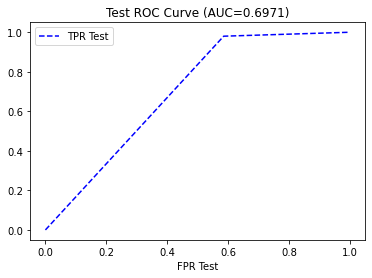

In [60]:
roc_df_test_svm.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_svm})",
)